
# Data Input

The datasets used in this project are available from ['The Cancer Genome Atlas' (TCGA)](www.http://cancergenome.nih.gov/) consortium.  Clinical and RNA-seq gene count data sets can be downloaded via a provided data portal, or using an R package called [TCGA2STAT](https://cran.r-project.org/web/packages/TCGA2STAT/index.html).  The R script used to download the data sets for this project and write files locally in [feather](https://github.com/wesm/feather)  format are available in the project repository [here](https://github.com/CCThompson82/MLE_capstone/tree/master/Dataset_setup).  Datasets are also stored in this project's repository [here](https://github.com/CCThompson82/MLE_capstone/tree/master/feather_files).  The R script is not necessary for dataset download, but can be run locally to obtain the most up to date clinical information from TCGA.  

In [1]:
%run -i Dataset_cleanup/arrange_DF.py

Clinical data set imported!
Features: 21 
Patients: 499

The following features do not provide any information: 
['Composite.Element.REF' 'ethnicity' 'gender' 'pathologicstage'
 'pathologyMstage' 'tumortissuesite'] 

Variables that are not known at initial diagnosis: 
['daystodeath' 'daystolastfollowup' 'daystopsa' 'histologicaltype'
 'numberoflymphnodes' 'pathologyTstage' 'radiationtherapy' 'residualtumor'
 'vitalstatus'] 

Variables that are known at the time of diagnosis:
['clinical_index' 'dateofinitialpathologicdiagnosis' 'gleasonscore'
 'pathologyNstage' 'psavalue' 'race' 'yearstobirth']


Gene Counts data set imported!
Features: 20501 
Patients: 497


In [2]:
print gene_counts.iloc[0:3, 0:3]

                 A1BG    A1CF    A2BP1
gc_index                              
TCGA-2A-A8VL  67.9197  0.0000  25.2317
TCGA-2A-A8VO  17.9448  0.0000  17.9448
TCGA-2A-A8VT  17.1029  0.3676   1.8382


In [3]:
"""Transform gene counts data set into normal format"""
def transformation(dataset) :
    print "\n\nTransforming gene counts to transcript per million (TPM)"
    read_count = dataset.sum(axis = 1) #get the total reads for each sample
    for r in xrange(0,dataset.shape[0],1) :
        dataset.iloc[r,:] = 1000000 * dataset.iloc[r] / read_count.iloc[r] #transform each read abundance (rsem) by the sample reads / million
    if sum(  dataset.sum(axis = 1).round(decimals=0) == 1e6) == dataset.shape[0] :  #the sum of each row in the transformed df should be 1000000.  if every row is transformed correctly, print statement
        print "\nTransformation Successful!\n"
        print dataset.shape[0],'Gene count estimate profiles have been transformed from gene counts to transcripts per million reads (TPM)'
    else :
        print "\nError in gene count transformation to TPM"
    return(dataset)

In [4]:
X_all = transformation(gene_counts)



Transforming gene counts to transcript per million (TPM)

Transformation Successful!

497 Gene count estimate profiles have been transformed from gene counts to transcripts per million reads (TPM)


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

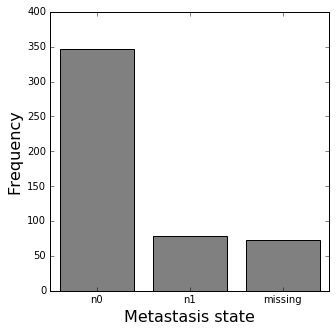

In [6]:
D = (('n0', y_all[y_all =='n0'].shape[0]), 
     ('n1', y_all[y_all =='n1'].shape[0]), 
     ('missing' , y_all[y_all.isnull()].shape[0]))
exp_fig = plt.figure(figsize=(5 , 5))
A = exp_fig.add_subplot(1,1,1)
ind = A.bar(range(0,3), height= [D[0][1], D[1][1], D[2][1]], align='center', color = 'grey')
A.set_xticks(range(0,3))
A.set_ylabel('Frequency', fontsize=16)
A.set_xlabel('Metastasis state', fontsize=16)
A.set_ylim(0,400)
A.set_xticklabels([D[0][0], D[1][0], D[2][0]])  #Must be a better way to do this as tuples (D, in this case) are not ordered?
ep = plt.show
exp_fig.savefig('Figures/LabelCount.png')

#### Gleason Score versus Metastasis analysis
The Gleason score is the gold-standard diagnostic test for cancer severity, but is not highly correlative with metastatic disease.  

In [7]:
clinical['gleasonscore'] = pd.to_numeric(clinical['gleasonscore'], errors= 'coerce')
clinical['gleasonscore'].isnull().any()

False

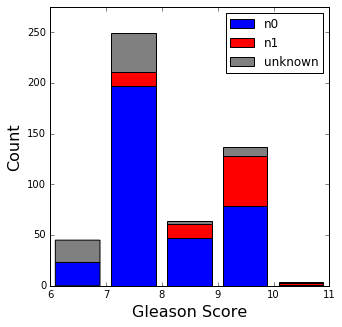

In [8]:
GS_hist = plt.figure(figsize=(5,5))
A = GS_hist.add_subplot(1,1,1)
sub = (('n1', ))

subs = [clinical.loc[y_all[y_all == 'n0'].index]['gleasonscore'],
        clinical.loc[y_all[y_all == 'n1'].index]['gleasonscore'],
        clinical.loc[y_all[y_all.isnull()].index]['gleasonscore']]

bins = [5.99, 6.99, 7.99, 8.99, 9.99, 10.99]
A.hist(subs, bins, label =['n0', 'n1', 'unknown'], color = ['blue','red','grey'], stacked = True)
A.set_ylim(0,275)
A.set_ylabel('Count', fontsize=16)
A.set_xlabel('Gleason Score', fontsize =16)
A.legend()
plt.show
GS_hist.savefig('Figures/GleasonHist.png')

It appears that no metastases are recorded in those specimens graded at a Gleason score of 6.  This represents an opportunity to replace the missing data label with the most likely pathology state, n0, to more efficiently use the small data set.  

In [9]:
"""Define the indices where gleasonscore == 6 and pathologyNstage is null"""
set(y_all[y_all.isnull()].index).intersection(list(clinical[clinical['gleasonscore'] == 6].index))

{'TCGA-2A-A8VO',
 'TCGA-2A-AAYO',
 'TCGA-CH-5738',
 'TCGA-G9-6342',
 'TCGA-G9-6347',
 'TCGA-G9-6371',
 'TCGA-G9-7509',
 'TCGA-H9-A6BX',
 'TCGA-HC-7075',
 'TCGA-HC-7077',
 'TCGA-HC-8213',
 'TCGA-HC-8259',
 'TCGA-J4-A67Q',
 'TCGA-J4-A83K',
 'TCGA-J9-A8CN',
 'TCGA-M7-A720',
 'TCGA-V1-A8WN',
 'TCGA-V1-A8WS',
 'TCGA-V1-A9OF',
 'TCGA-V1-A9OQ',
 'TCGA-V1-A9OT',
 'TCGA-XJ-A9DQ'}

In [10]:
y_all.loc[set(y_all[y_all.isnull()].index).intersection(list(clinical[clinical['gleasonscore'] == 6].index))] = 'n0'

/Users/ccthomps/anaconda/envs/python2.7/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


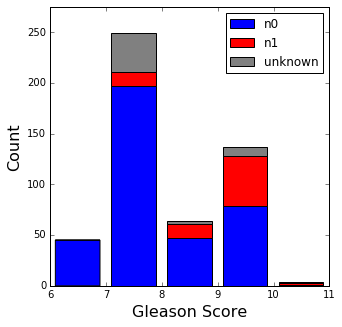

In [11]:
GS_hist = plt.figure(figsize=(5,5))
A = GS_hist.add_subplot(1,1,1)
sub = (('n1', ))

subs = [clinical.loc[y_all[y_all == 'n0'].index]['gleasonscore'],
        clinical.loc[y_all[y_all == 'n1'].index]['gleasonscore'],
        clinical.loc[y_all[y_all.isnull()].index]['gleasonscore']]

bins = [5.99, 6.99, 7.99, 8.99, 9.99, 10.99]
A.hist(subs, bins, label =['n0', 'n1', 'unknown'], color = ['blue','red','grey'], stacked = True)
A.set_ylim(0,275)
A.set_ylabel('Count', fontsize=16)
A.set_xlabel('Gleason Score', fontsize =16)
A.legend()
plt.show
GS_hist.savefig('Figures/GleasonHist2.png')

## Gene Activation (Gene counts) Dataset
The starting dataset, **'X_all'**, includes the transformed transcript per million (TPM) estimates for all RNA-seq profiles.  However some of the observations in this set do not have corresponding y_labels, as the clinical data set contains missing information.

Therefore X_all was trimmed to include only those observations where a finite y label exists, to yield **'X'**.  

In [12]:
print "Total observations in original dataset:",clinical.shape[0]

not_labeled = y_all[y_all.isnull()] 
y = y_all[y_all.notnull()]

print "\nObservations with metastasis label:",y.shape[0] 
print "Unlabeled observations (removed:)",not_labeled.shape[0] 


Total observations in original dataset: 499

Observations with metastasis label: 448
Unlabeled observations (removed:) 51


In [13]:
"""Limit X to only observations where a target label is present."""
X = X_all.loc[set(y.index).intersection(X_all.index)]  #Only observations that also have a known metastasis state are kept.
y = y.loc[set(X.index).intersection(y.index)]
print "X dimensions:",X.shape,"\ny dimensions:",y.shape 

X dimensions: (446, 20501) 
y dimensions: (446,)


In [14]:
X_no_y = X_all.loc[list(not_labeled.index)]
print "Dimensions of unlabeled dataset:",X_no_y.shape 

Dimensions of unlabeled dataset: (51, 20501)


In [15]:
"""Check to determine if any clinical information is missing"""
X.isnull().values.any()

False

## Data Visualization

In [16]:
gleason = clinical['gleasonscore']
#print(gleason.shape)
age = pd.to_numeric(clinical['yearstobirth'], errors = 'coerce')
age.fillna(value = np.mean(age), inplace=True)
psa = pd.to_numeric(clinical['psavalue'], errors= 'coerce')
psa.fillna(value = np.mean(psa), inplace =True)
#gleason = gleason.loc[y.index]

clinicalDF_all = pd.DataFrame({'gleason': gleason,
                            'age':age ,
                            'psa' : psa,
                            'y' : y_all}, index=X_all.index)
clinicalDF = clinicalDF_all.loc[y.index, :]

In [17]:
clinicalDF.drop(['y'], axis=1, inplace = True)

In [18]:
clinicalDF = clinicalDF.reindex(y.index)

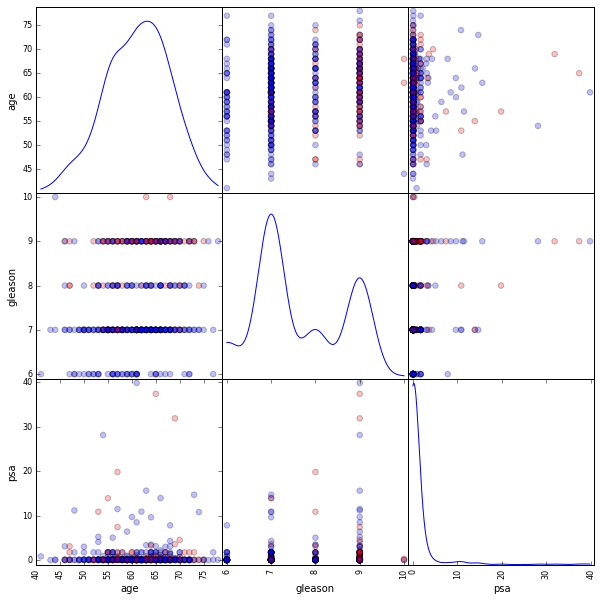

In [19]:
sm = pd.scatter_matrix(clinicalDF, 
                       alpha=0.25, 
                       figsize= (10,10), 
                       diagonal = 'kde', 
                       c = y.replace({'n1': 'red','n0':'blue'}), 
                       s = 125)

plt.savefig("Figures/ClinScatterMatrix.png")

In [20]:
X = X.reindex(y.index)

In [21]:
from sklearn.feature_selection import SelectKBest, f_classif
K_selector = SelectKBest(f_classif, k = 'all') # using k=all here and will filter based on F-stat later.  
K = K_selector.fit(X, y)
K_df = pd.DataFrame({'Gene':X.columns, 'F_score':K.scores_})
K_df.dropna(inplace=True)

/Users/ccthomps/anaconda/envs/python2.7/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 1595  1815  2267  4324  4341  4342  4343  4344  4345  4346  4347  4779
  4780  4781  4782  4787  4790  4791  4794  4795  4801  4803  5259  6032
  6776  6780  6783  7445  7551  7632  7633  7634  7635  7636  7732  9275
  9277  9287  9291  9419  9421  9423  9495 10092 11101 11929 12028 12488
 12527 12593 12606 13749 13963 14015 14129 14130 14131 14132 14726 14727
 14729 15109 15111 15112 16536 16538 16539 16541 16542 16543 16545 16546
 16547 16548 16549 16550 16576 16605 16608 16648 16668 16669 16670 16671
 16672 16673 16674 16675 16676 16677 16678 16679 16680 16681 16682 16683
 16684 16685 16686 16687 16688 16689 16690 16691 16692 16693 16694 16695
 16696 16697 16698 16699 16700 16701 16702 16703 16704 16705 16706 16707
 16708 16709 16710 16711 16712 16713 16714 16715 16716 16717 16718 16720
 16721 16722 16723 16724 16725 16726 16728 16729 167

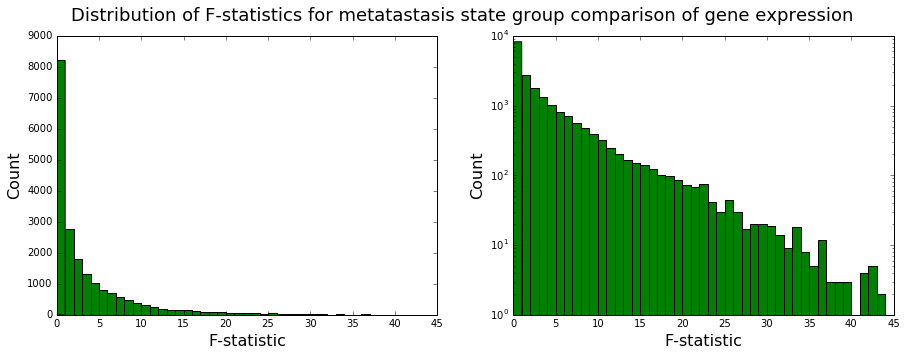

In [22]:
F_fig = plt.figure(figsize=(15,5))
A = F_fig.add_subplot(1,2,1)
A.hist(K_df['F_score'], bins=range(0,45,1), facecolor='green')
#A.set_yscale('log')
A.set_ylabel('Count', fontsize=16)
A.set_xlabel("F-statistic", fontsize=16)
F_fig.suptitle("Distribution of F-statistics for metatastasis state group comparison of gene expression", fontsize = 18)
B = F_fig.add_subplot(1,2,2)
B.hist(K_df['F_score'], bins=range(0,45,1), facecolor='green')
B.set_yscale('log')
B.set_ylabel('Count', fontsize=16)
B.set_xlabel("F-statistic", fontsize=16)
#B.set_title("Distribution of F-statistics for metatastasis state group comparison of gene expression", fontsize = 18)
plt.show()
F_fig.savefig("Figures/FDist.png")

# Analysis
## Prepare for Analysis
### Generate Scoring Functions

In [23]:
from sklearn.metrics import matthews_corrcoef, fbeta_score, classification_report, log_loss
from sklearn.cross_validation import cross_val_score

In [24]:
"""Scorers needed throughout code:"""
from sklearn.metrics import make_scorer
LL_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True, needs_threshold=False)
MCC_scorer = make_scorer(matthews_corrcoef, greater_is_better=True, needs_proba=False, needs_threshold=False)
fbeta_scorer = make_scorer(fbeta_score, greater_is_better=True, needs_proba=False, needs_threshold=False, pos_label='n1', beta = 2)

### Import Logistic Regression Algorithms

In [25]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

### Set Seed and Folds for Cross Validation

In [26]:
seed = 123
folds = 4

### Handles for Graph legends

In [27]:
import matplotlib.patches as mpatches
blue = mpatches.Patch(color ='blue', label ='n0')
red = mpatches.Patch(color='red', label = 'n1')

### Train Test Split

In [28]:
from sklearn.cross_validation import train_test_split
train_k = int(round(len(y)*0.70))
test_k = int(len(y) - train_k)

In [29]:
"""Split samples into train and test sets, stratified by Gleason score"""
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size= test_k, 
                                                    train_size = train_k,
                                                    random_state = seed,
                                                    stratify = clinicalDF['gleason'])

In [30]:
clinicalDF_train = clinicalDF.loc[X_train.index,:]
clinicalDF_test = clinicalDF.loc[X_test.index,:]

## Benchmark

### Clinical Information Benchmark

In [31]:
clf_LR_clin = LogisticRegression(penalty='l2',
                              dual=False,
                              tol=0.0001,
                              C=1,
                              fit_intercept=True,
                              intercept_scaling=1,
                              class_weight='balanced',
                              random_state=123,
                              solver='liblinear',
                              max_iter=100,
                              multi_class='ovr',
                              verbose=0,
                              warm_start=False,
                              n_jobs=1)

clf_LR_clin.fit(clinicalDF_train, y_train)  #use training set for model learning

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

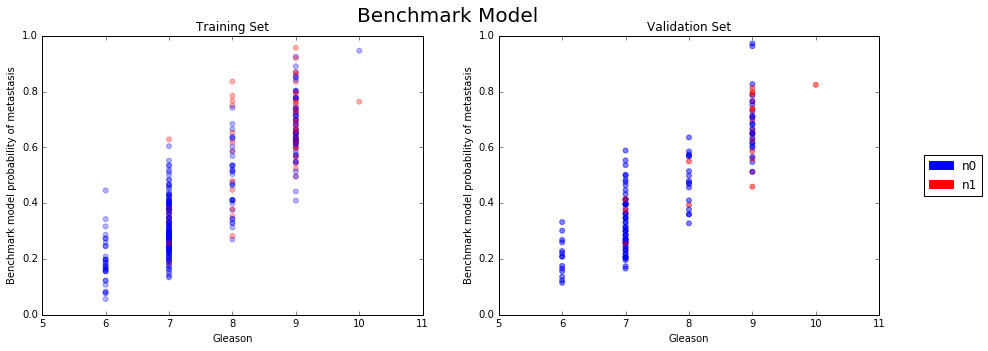

In [32]:
clf_LR_clin = LogisticRegression(penalty='l2',
                              dual=False,
                              tol=0.0001,
                              C=1,
                              fit_intercept=True,
                              intercept_scaling=1,
                              class_weight='balanced',
                              random_state=123,
                              solver='liblinear',
                              max_iter=100,
                              multi_class='ovr',
                              verbose=0,
                              warm_start=False,
                              n_jobs=1)

clf_LR_clin.fit(clinicalDF_train, y_train)  #use training set for model learning

bench_fig = plt.figure(figsize=(15,5))
A= bench_fig.add_subplot(1,2,1)
B = bench_fig.add_subplot(1,2,2)
A.scatter(clinicalDF_train.loc[:,'gleason'], 
          clf_LR_clin.predict_proba(clinicalDF_train)[:,1], 
          color = y_train.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.3,
          s = 25)
A.set_ylabel('Benchmark model probability of metastasis')
A.set_ylim(0,1)
B.set_ylim(0,1)
A.set_xlabel('Gleason')
plt.suptitle('Prognosis of metastasis risk based on features available at presentation', fontsize=20)
A.set_title('Training Set')
B.set_title('Validation Set')
B.scatter(clinicalDF_test.loc[:,'gleason'],
          clf_LR_clin.predict_proba(clinicalDF_test)[:,1],
          color = y_test.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.5,
          s = 25)
B.set_xlabel('Gleason')
B.set_ylabel('Benchmark model probability of metastasis')
bench_fig.legend(labels = ['n0', 'n1'], handles = [blue, red], loc = 5)
bench_fig.suptitle("Benchmark Model", fontsize=20)
plt.show
bench_fig.savefig('Figures/benchmark.png')

In [33]:
print(pd.DataFrame({'features':clinicalDF.columns, 'coefficient': clf_LR_clin.coef_[0]}))

   coefficient features
0    -0.070746      age
1     0.839065  gleason
2     0.068551      psa


In [34]:
"Benchmark Performance on Train dataset"
print clf_LR_clin 
print '\nNull F beta: ', fbeta_score(y_train, clf_LR_clin.predict(clinicalDF_train), pos_label='n1',beta=2)
print '\nMCC: ',matthews_corrcoef(y_train, clf_LR_clin.predict(clinicalDF_train)),"\n" 
print classification_report(y_train, clf_LR_clin.predict(clinicalDF_train), labels = ['n0','n1']) 
print '\nLogLoss: ', log_loss(y_train.replace({'n0':0, 'n1':1}), 
         clf_LR_clin.predict_proba(clinicalDF_train)[:,1]) 

training_stat = pd.DataFrame({'F2': fbeta_score(y_train, clf_LR_clin.predict(clinicalDF_train), pos_label='n1',beta=2),
                            'MCC': matthews_corrcoef(y_train, clf_LR_clin.predict(clinicalDF_train)),
                            'LogLoss':log_loss(y_train.replace({'n0':0, 'n1':1}), 
                                      clf_LR_clin.predict_proba(clinicalDF_train)[:,1])}, index = ['clinical_only'])

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Null F beta:  0.597667638484

MCC:  0.337716768706 

             precision    recall  f1-score   support

         n0       0.92      0.70      0.79       256
         n1       0.34      0.73      0.47        56

avg / total       0.82      0.70      0.73       312


LogLoss:  0.588260727696


In [35]:
"Benchmark Performance on Test dataset"
print clf_LR_clin 
print '\nNull F beta: ', fbeta_score(y_test, clf_LR_clin.predict(clinicalDF_test), pos_label='n1',beta=2) 
print '\nMCC: ',matthews_corrcoef(y_test, clf_LR_clin.predict(clinicalDF_test)),"\n" 
print classification_report(y_test, clf_LR_clin.predict(clinicalDF_test), labels = ['n0','n1']) 
print '\nLogLoss: ', log_loss(y_test.replace({'n0':0, 'n1':1}), 
         clf_LR_clin.predict_proba(clinicalDF_test)[:,1]) 

metric_stat = pd.DataFrame({'F2': fbeta_score(y_test, clf_LR_clin.predict(clinicalDF_test), pos_label='n1',beta=2),
                            'MCC': matthews_corrcoef(y_test, clf_LR_clin.predict(clinicalDF_test)),
                            'LogLoss':log_loss(y_test.replace({'n0':0, 'n1':1}), 
                                      clf_LR_clin.predict_proba(clinicalDF_test)[:,1])}, index = ['clinical_only'])

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Null F beta:  0.602836879433

MCC:  0.352973753608 

             precision    recall  f1-score   support

         n0       0.93      0.71      0.81       111
         n1       0.35      0.74      0.47        23

avg / total       0.83      0.72      0.75       134


LogLoss:  0.601391710058


## Feature Reduction
### Import Functions

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Gini Importance Filter

In [37]:
clf_RF = RandomForestClassifier(n_estimators=1000, 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features= 'auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=1, 
                                random_state=seed, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight='balanced')


In [38]:
clf_RF.fit(X, y)
Gini_DF = pd.DataFrame({'Gini' :clf_RF.feature_importances_}, index=X.columns).sort_values(by = ['Gini'], axis = 0, ascending = False)
#Gini_DF.reset_index(inplace=True)
print(Gini_DF.head())

              Gini
EDN3      0.003682
FKBP15    0.001854
HIST1H3J  0.001813
GNE       0.001798
SPAG1     0.001708


In [39]:
"""Set k number of genes to retain"""
k = 75

### Stability Experiment

genes = Gini_DF.index[0:k] # gene list from first instance  
for x in [5, 54, 543, 5432, 54321] :
    clf_RF = RandomForestClassifier(n_estimators=1000, 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features= 'auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=1, 
                                random_state=x, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight='balanced')
    clf_RF.fit(X, y)
    Gini_DF = pd.DataFrame({'Gini' :clf_RF.feature_importances_}, index=X.columns).sort_values(by = ['Gini'], axis = 0, ascending = False)
    genes = set(genes).intersection(Gini_DF.index[0:k])
    print('Number of Consistent (Stable) Genes:',len(genes))

In [40]:
"""The genes most commonly determined in the slow iterative process above are listed below.  By commenting out the cycle above
and just covering up the `genes` variable here, the code runs faster.  For confirmation, one may turn the code type of the 
cell above to 'code' instead of 'markdown' and run the process to check the subset below."""

genes = ['HIST1H3J',
         'EDN3',
         'FKBP15',
         'FOXS1',
         'GNE',
         'HMGB2',
         'MAP6D1',
         'SNAPIN',
         'SPAG1',
         'UBE2D2',
         'ZNRF3', 
         'DPM1',
         'VPS36']



In [41]:
"""Subset X to include only the k best features from the Gini Importance table"""
X_k = X.loc[:,genes]

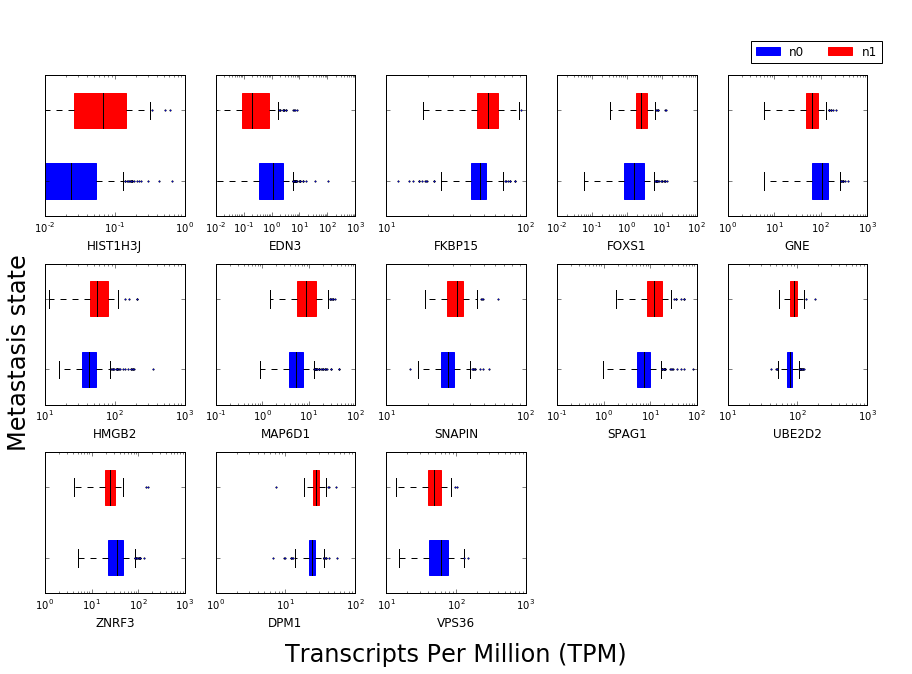

In [42]:

fig = plt.figure(figsize=(12,8))
for i in range(0,len(X_k.columns),1) :
    ax = fig.add_subplot(3,5,i+1)
    df0 = list(X_k.ix[y.loc[y=='n0'].index,i])
    df1 = list(X_k.ix[y.loc[y=='n1'].index,i])
    data = [df0,df1]
    A = ax.boxplot(data, positions = [1,2], vert = False, widths = 0.5, patch_artist=True)
    plt.setp(A['boxes'][1], color='red')
    plt.setp(A['boxes'][0], color='blue')
    plt.setp(A['medians'], color = 'black')
    plt.setp(A['whiskers'], color = 'black')
    plt.setp(A['fliers'], color = 'black', marker = '.', markersize = 3)
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xlabel(X_k.columns[i], fontsize=12)
    ax.set_xscale('log')
fig.tight_layout()
fig.legend(labels = ['n0', 'n1'], handles= [blue,red], ncol = 2, loc = 'lower center', bbox_to_anchor = (.945, 1.05))
fig.text(-.005, 0.5, 'Metastasis state', ha='center', va='center', fontsize=24,rotation='vertical')
fig.text(.5, -.025, 'Transcripts Per Million (TPM)', ha='center', va='center', fontsize=24)
fig.savefig('Figures/boxplots.png', dpi = 300, bbox_inches='tight')
plt.show()


### Transform reduced feature dataframe to standard scale

In [43]:
scaler = StandardScaler()
Xs = pd.DataFrame(scaler.fit_transform(X_k), columns = X_k.columns, index = X_k.index)


### PCA transformation
#### Train on the scaled feature set

In [44]:
components = 3

In [45]:
pca = PCA(n_components = components, whiten=False)
pca.fit(Xs)

PCA(copy=True, n_components=3, whiten=False)

#### Transform with the trained PCA function

In [46]:
Xpc = pd.DataFrame(pca.transform(Xs), columns = range(0,components,1), index = X.index)

#### Visualize the PCA transformation

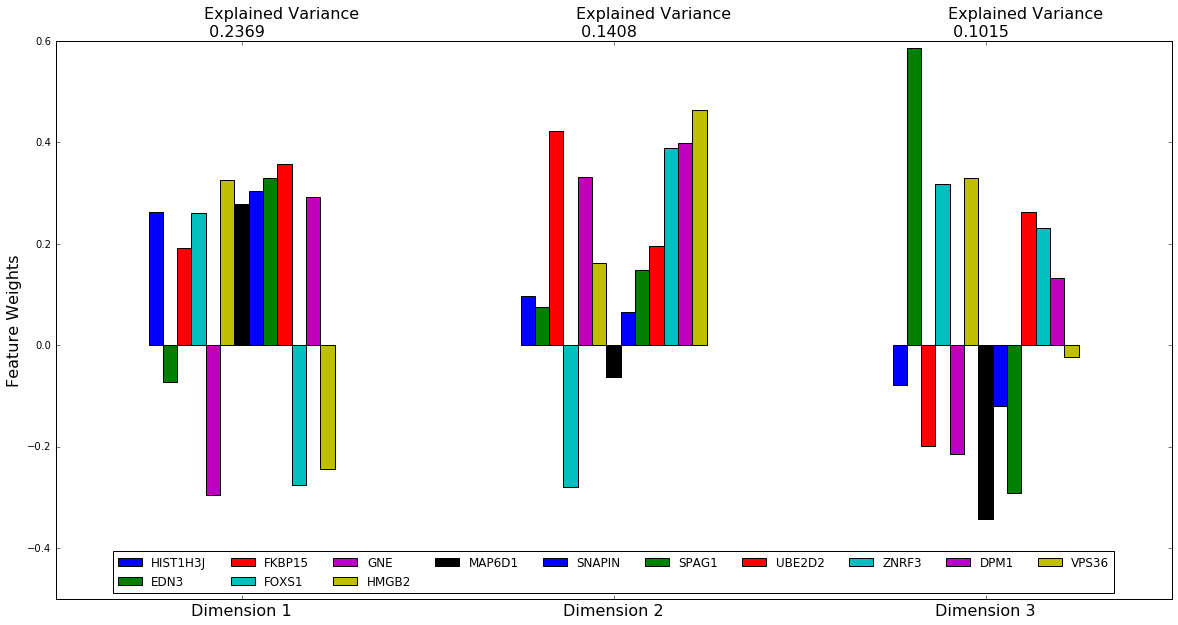

In [47]:
%run -i 'support files/renders_PCA.py'
pca_results(Xs, pca)
plt.savefig('Figures/pcaEV.png', dpi =500)

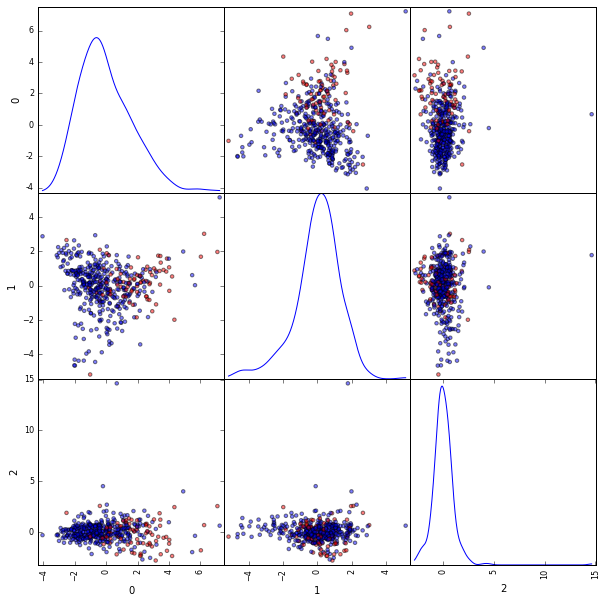

In [48]:

sm = pd.scatter_matrix(Xpc, 
                       alpha=0.5, 
                       figsize= (10,10), 
                       diagonal = 'kde', 
                       c = y.replace({'n1': 'red','n0':'blue'}), 
                       s = 50)
plt.savefig("Figures/pcaScatter.png", dpi = 300)

#### Appropriate the PCA transformed dataset via the current train, test split index

In [49]:
X_train, X_test = Xpc.loc[X_train.index, :], Xpc.loc[X_test.index, :]

## Train the Logistic Regression Algorithm
Training with the first three principle components with cross validation to determine the optimal C parameter.

In [50]:
clf_LR = LogisticRegression(penalty='l2',
                              dual=False,
                              tol=0.0001,
                              C=1,
                              fit_intercept=True,
                              intercept_scaling=1,
                              class_weight='balanced',
                              random_state=123,
                              solver='liblinear',
                              max_iter=100,
                              multi_class='ovr',
                              verbose=0,
                              warm_start=False,
                              n_jobs=1)
clf_LR.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

### Visualize Model Performance on Training and Test sets

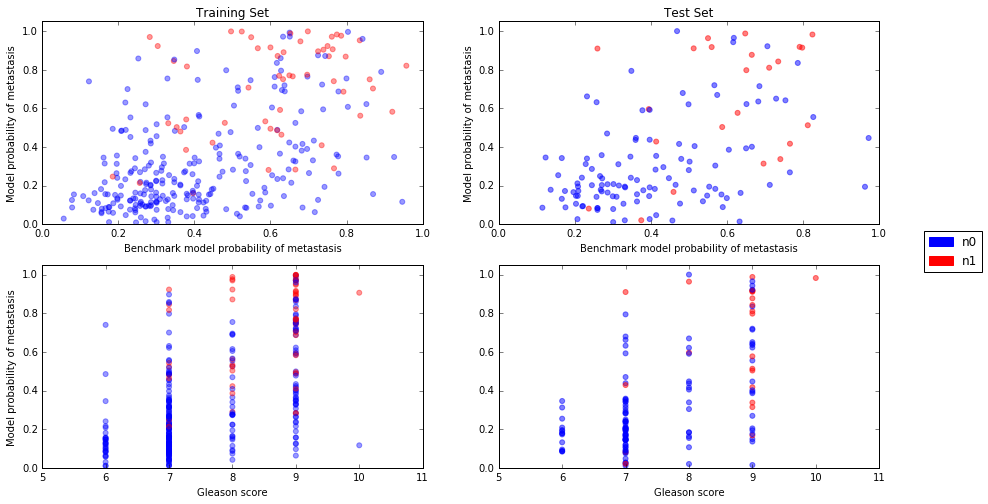

In [51]:
%run -i 'Support Files/capstone_graphs.py'
fig.savefig('Figures/PC3.png')

### Measure Performance on the held-out test set

In [52]:
run_name = '3_PCs'
%run -i 'Support Files/capstone_performance.py'

Model:
LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

             precision    recall  f1-score   support

         n0       0.93      0.82      0.87       111
         n1       0.44      0.70      0.54        23

avg / total       0.85      0.80      0.81       134


Log Loss:  0.545345785628


                     F2   LogLoss       MCC
clinical_only  0.602837  0.601392  0.352974
3_PCs          0.625000  0.545346  0.438497


## Optimize the Logistic Regression Model

In [53]:
clf_LR = LogisticRegressionCV(Cs=10, 
                              fit_intercept=True, 
                              cv=folds, 
                              dual=False, 
                              penalty='l2', 
                              scoring='log_loss', 
                              solver='liblinear', 
                              tol=0.0001, 
                              max_iter=100, 
                              class_weight='balanced', 
                              n_jobs=1, 
                              verbose=0, 
                              refit=True, 
                              intercept_scaling=1.0, 
                              multi_class='ovr', 
                              random_state=seed)
clf_LR.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

In [54]:
print("The optimal C term: ",clf_LR.C_)

('The optimal C term: ', array([ 10000.]))


### Visualize Model Performance on Training and Test sets

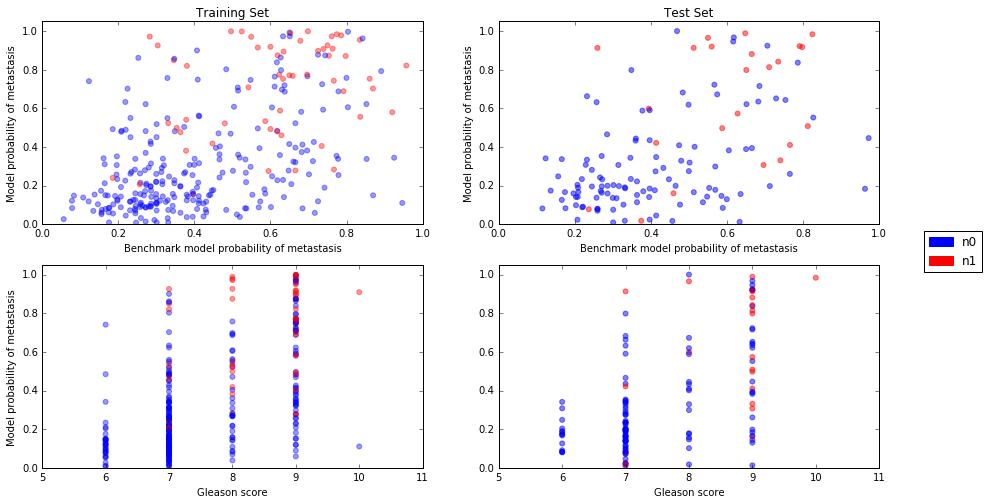

In [55]:
%run -i 'Support Files/capstone_graphs.py'
fig.savefig('Figures/optPC3.png')

### Measure Performance on the held-out test set

In [56]:
run_name = '3_PCs_optimized'
%run -i 'Support Files/capstone_performance.py'

Model:
LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

             precision    recall  f1-score   support

         n0       0.92      0.82      0.87       111
         n1       0.43      0.65      0.52        23

avg / total       0.83      0.79      0.81       134


Log Loss:  0.545857129409


                       F2   LogLoss       MCC
clinical_only    0.602837  0.601392  0.352974
3_PCs            0.625000  0.545346  0.438497
3_PCs_optimized  0.590551  0.545857  0.405145


### Incorporate Gleason score

In [57]:
X_train.loc[:,'gleason'] = clinicalDF.loc[X_train.index,'gleason']
X_test.loc[:,'gleason'] = clinicalDF.loc[X_test.index, 'gleason']

### Retrain Logistic Regression model with CV for C term

In [58]:
clf_LR = LogisticRegressionCV(Cs=10, 
                              fit_intercept=True, 
                              cv=folds, 
                              dual=False, 
                              penalty='l2', 
                              scoring='log_loss', 
                              solver='liblinear', 
                              tol=0.0001, 
                              max_iter=100, 
                              class_weight='balanced', 
                              n_jobs=1, 
                              verbose=0, 
                              refit=True, 
                              intercept_scaling=1.0, 
                              multi_class='ovr', 
                              random_state=seed)
clf_LR.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

#### Visualize Model Performance
Trained on First 3 PCs + gleason score

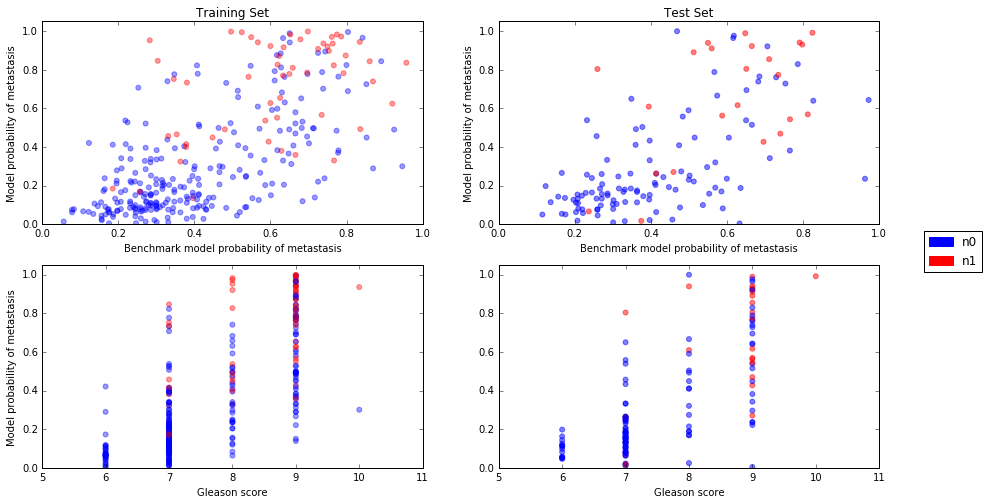

In [59]:
%run -i 'Support Files/capstone_graphs.py'
plt.savefig('Figures/PC3Gleason.png')

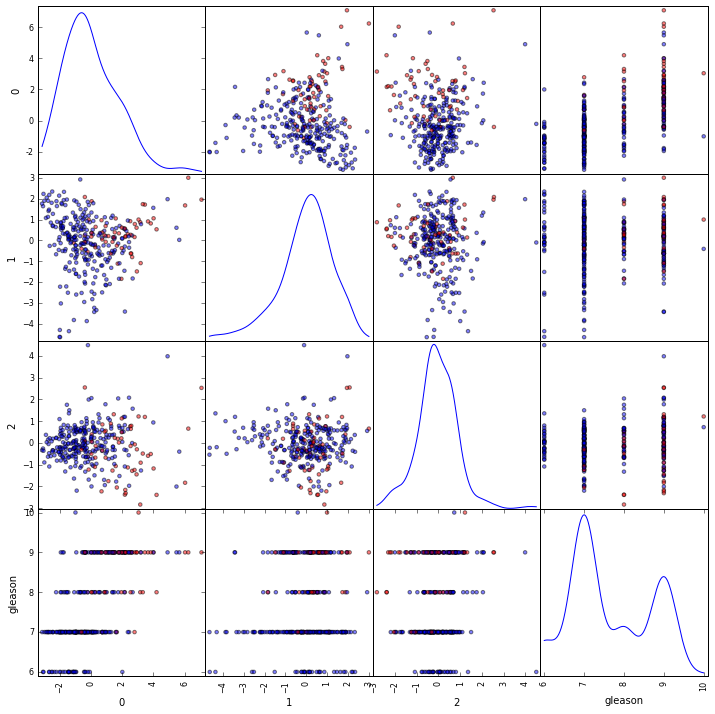

In [60]:
sm = pd.scatter_matrix(X_train, 
                       alpha=0.5, 
                       figsize= (12,12), 
                       diagonal = 'kde', 
                       c = y_train.replace({'n1': 'red','n0':'blue'}), 
                       s = 50)
plt.savefig('Figures/FeatureSM.png')

#### Performance Measure

In [61]:
run_name = 'Final_Model'
%run -i 'Support Files/capstone_performance.py'

Model:
LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

             precision    recall  f1-score   support

         n0       0.94      0.81      0.87       111
         n1       0.45      0.74      0.56        23

avg / total       0.85      0.80      0.82       134


Log Loss:  0.517856221515


                       F2   LogLoss       MCC
clinical_only    0.602837  0.601392  0.352974
3_PCs            0.625000  0.545346  0.438497
3_PCs_optimized  0.590551  0.545857  0.405145
Final_Model      0.653846  0.517856  0.460060


#### Is each feature important for model performance?

In [62]:
pd.DataFrame({'Component': X_train.columns, 'coef': clf_LR.coef_[0]})

,Component,coef
0,0,0.763731
1,1,0.460511
2,2,-0.458334
3,gleason,0.504635


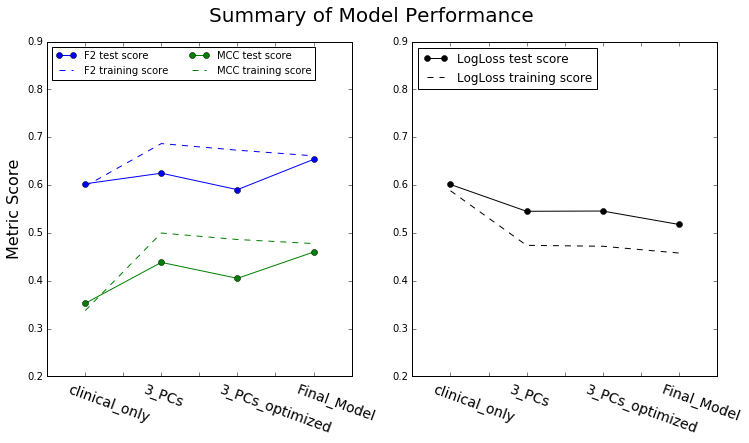

In [63]:
%run -i 'Support Files/final_graph.py'
fig.savefig('Figures/FF.png')

## Conclusions and Discussion

### Function for Prostate Cancer Metastasis Risk

In [64]:
def risk_function(barcode, DF, clinDF, genes, scaler, fit_pca, fit_clf) :
    self = DF.loc[barcode,genes].reshape(1,-1)
    self = pd.DataFrame(scaler.transform(self))
    self = pd.DataFrame(fit_pca.transform(self), index = [barcode])
    self['gleason'] = clinDF.loc[barcode,'gleasonscore']
    return(fit_clf.predict_proba(self)[0,1])
    



In [65]:
risk = []
for x in not_labeled.index :
    risk.append(risk_function(barcode = x,
              DF = X_all,
              clinDF = clinical,
              genes = genes,
              fit_pca = pca,
              scaler = scaler,
              fit_clf = clf_LR))
model_risk = pd.Series(risk, index=not_labeled.index)

In [66]:
clinicalDF_all.drop(['y'], axis=1, inplace = True)

In [67]:
bench_risk = pd.Series(clf_LR_clin.predict_proba(clinicalDF_all.loc[not_labeled.index,:])[:,1])

In [68]:
n0_question = X_all.loc[y[y!='n1'].index, :]

In [69]:
risk = []
for x in n0_question.index :
    risk.append(risk_function(barcode = x,
              DF = n0_question,
              clinDF = clinical,
              genes = genes,
              fit_pca = pca,
              scaler = scaler,
              fit_clf = clf_LR))
n0_risk = pd.Series(risk, index=n0_question.index)

### Visualize unlabeled and 'non-metastatic' cases from the TCGA cohort

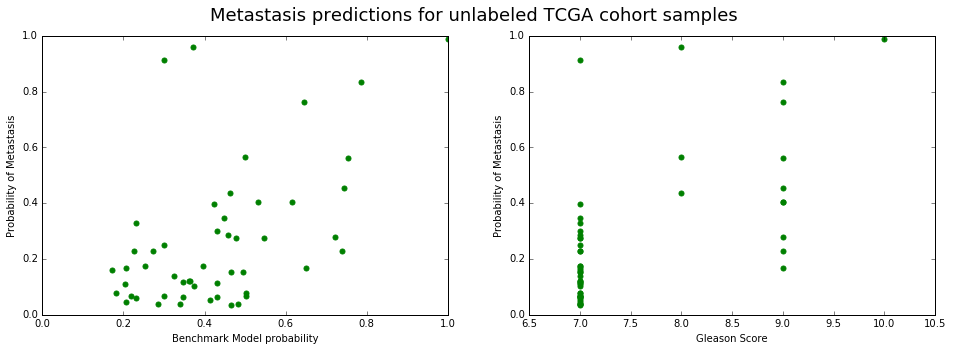

In [70]:
%run -i 'Support Files/free-form.py'
fig.savefig('Figures/missing.png')

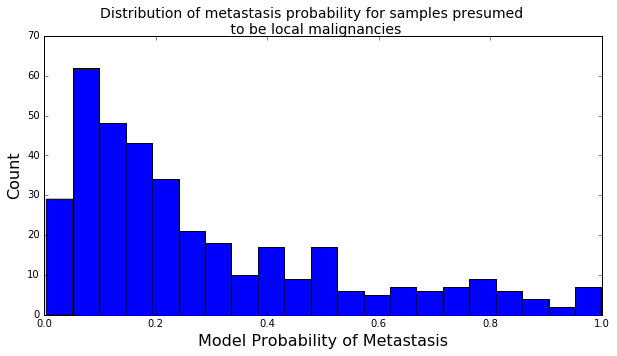

In [71]:
%run -i 'Support Files/free-form2.py'
fig.savefig('Figures/N0Analysis.png')

It is important to remember that the dataset utilized in this project is longitudinal and active, and indeed some cases listed as 'n0' will eventually be diagnosed as 'n1'.  Even though the model was trained on such false-negative labeled cases, some of the 'n0' class are still predicted as highly likely to metastasize.  If the dataset were linked somehow to patient records (for ethical purposes, no such link exists), then these patients should be monitored with extreme care for signs of metastasis based on the predictions made by the project model.

In [72]:
n0_risk[n0_risk > 0.75].sort_values(ascending = False)

clinical_index
TCGA-EJ-8472    0.999128
TCGA-CH-5761    0.995148
TCGA-HC-A9TE    0.988526
TCGA-EJ-5514    0.975689
TCGA-HC-7213    0.965272
TCGA-J4-AATZ    0.963862
TCGA-V1-A9OL    0.963687
TCGA-KK-A59V    0.941269
TCGA-FC-7961    0.920980
TCGA-HC-A9TH    0.893884
TCGA-V1-A9Z8    0.887022
TCGA-YL-A8SC    0.884298
TCGA-YL-A8HM    0.875546
TCGA-EJ-8469    0.843915
TCGA-HC-A4ZV    0.828934
TCGA-KK-A8IC    0.823988
TCGA-M7-A725    0.822323
TCGA-VP-AA1N    0.820220
TCGA-HC-A631    0.811804
TCGA-HC-A632    0.792710
TCGA-KK-A6E6    0.788010
TCGA-EJ-A65F    0.787878
TCGA-XK-AAIW    0.779127
TCGA-XJ-A9DI    0.777701
TCGA-HC-7742    0.776427
TCGA-HI-7168    0.765169
TCGA-ZG-A9ND    0.764147
TCGA-X4-A8KQ    0.762725
TCGA-KK-A6E0    0.760729
dtype: float64

### Sensitivity Analysis

In [73]:
benign = feather.read_dataframe('feather_files/benign.feather')

In [74]:
benign.set_index(['benign_index'], inplace = True)

In [75]:
benign.shape

(52, 20501)

In [76]:
benign_tpm = transformation(benign)



Transforming gene counts to transcript per million (TPM)

Transformation Successful!

52 Gene count estimate profiles have been transformed from gene counts to transcripts per million reads (TPM)


In [77]:
risk = []
for x in benign.index :
    risk.append(risk_function(barcode = x,
              DF = benign,
              clinDF = clinical,
              genes = genes,
              fit_pca = pca,
              scaler = scaler,
              fit_clf = clf_LR))
benign_risk = pd.Series(risk, index=benign.index)

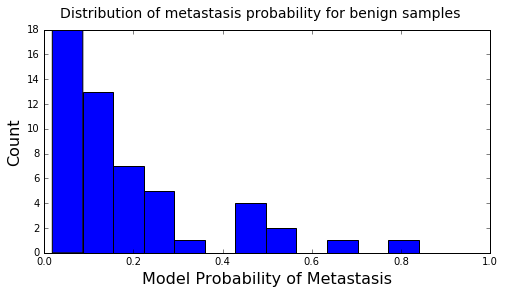

In [78]:

fig = plt.figure(figsize=(8,4))
A = fig.add_subplot(1,1,1)
A.hist(benign_risk.sort_values(ascending=False),
       bins=12,
       facecolor='blue')
#A.set_yscale('log')
A.set_ylabel('Count', fontsize=16)
A.set_xlim(0,1)
A.set_xlabel("Model Probability of Metastasis", fontsize=16)
fig.suptitle("Distribution of metastasis probability for benign samples", fontsize = 14)
plt.show()
fig.savefig("Figures/Sensitivity.png")